In [1]:
%load_ext watermark
%watermark -u -d -m -v -p numpy,matplotlib,iris,sattools,umtools,faamtools,pyveccalc

last updated: 2016-08-19 

CPython 3.5.2
IPython 5.1.0

numpy 1.10.4
matplotlib 1.5.2
iris 1.9.2
sattools 0.1
umtools 0.1.5
faamtools 0.2.3
pyveccalc 0.2.8

compiler   : GCC 4.8.2 20140120 (Red Hat 4.8.2-15)
system     : Linux
release    : 3.13.0-93-generic
machine    : x86_64
processor  : x86_64
CPU cores  : 4
interpreter: 64bit


In [2]:
%matplotlib inline

In [3]:
import datetime
import iris
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
from matplotlib.offsetbox import AnchoredOffsetbox
from mpl_toolkits.axes_grid1 import AxesGrid
from mpl_toolkits.axes_grid.anchored_artists import AnchoredText
import numpy as np
import os
import string
#
import umtools.irismode as umi
import umtools.utils as umu
import sattools as st
#
import map_plot_func as mymap
import mypaths
import mpl_func as mympl
import phys_meteo as met
import misc_utils as misc

### Matplotlib settings

In [4]:
pe = [PathEffects.withStroke(linewidth=2, foreground='w')]
mpl.rcParams['mathtext.default'] = 'regular'
fmt = 'pdf'
svfigkw = dict(dpi=300, bbox_inches='tight', format=fmt)

In [5]:
lchar_list = list(string.ascii_lowercase)

### Load model data

In [6]:
opj = os.path.join

In [7]:
iris.FUTURE.netcdf_promote = True
iris.FUTURE.cell_datetime_objects = True
um_res = umu.grdstep('km2p2')
fcst_init = '25_1200'

In [8]:
fcst_init_dt = datetime.datetime.strptime('201303'+fcst_init, '%Y%m%d_%H%M')

In [9]:
um_path = opj(mypaths.extdir, 'UM', 'exp_results', um_res.key, fcst_init, 'obs')

In [10]:
f_thetagrd = iris.load(opj(um_path, 'umnsa_t1-48_obs_11-14h_023'))

In [11]:
umi.replace_unknown_names(f_thetagrd)

### Extract variables

In [12]:
thetime = datetime.datetime(2013,3,26,11,30)

In [13]:
def time_constr(cube, dt=thetime):
    return iris.Constraint(time=umu.nearest_tval(cube, dt))

In [14]:
theta = f_thetagrd.extract_strict('air_potential_temperature')
theta = theta.extract(time_constr(theta))
pres = f_thetagrd.extract_strict('air_pressure')
pres = pres.extract(time_constr(pres))
cimixr = f_thetagrd.extract_strict('mass_fraction_of_cloud_ice_in_air')
cimixr = cimixr.extract(time_constr(cimixr))
cwmixr = f_thetagrd.extract_strict('mass_fraction_of_cloud_liquid_water_in_air')
cwmixr = cwmixr.extract(time_constr(cwmixr))

In [15]:
cosp_cpr = f_thetagrd.extract_strict('COSP: GBX-MEAN CSAT Ze MDL LEVELS')
cosp_cpr = cosp_cpr.extract(time_constr(cosp_cpr))

In [16]:
thtacoords = umi.get_model_real_coords(theta, dims='zyx')

In [17]:
cosp_coords = umi.get_model_real_coords(cosp_cpr, dims='zyx')

In [18]:
p0 = iris.coords.AuxCoord(1e5, long_name='reference_pressure', units='Pa')
Rd = iris.coords.AuxCoord(met.Rd, long_name='Specific gas constant for dry air', units='J kg^-1 K^-1')

In [19]:
airtemp = theta * ( (pres / p0) ** (met.Rd / met.cp) )
airtemp.rename('air_temperature')
# airdens = pres / (Rd * airtemp)
# airdens.rename('air_density')
# cidens = cimixr * airdens
# cidens.rename('mass_density_cloud_ice_in_air')
# cwdens = cwmixr * airdens
# cwdens.rename('mass_density_cloud_liquid_water_in_air')

In [20]:
airdens_data = pres.data / (Rd.points[0] * airtemp.data)

In [21]:
cidens_data = cimixr.data * airdens_data
cwdens_data = cwmixr.data * airdens_data

#### Bounding box

In [22]:
bbox = (-2.5, 10, 71, 80)

### Cloudsat

In [23]:
cloudsat_h1 = 0  # km
cloudsat_h2 = 6  # km
cloudsat_nz = 500  # Number of pixels in the vertical.
cloudsat_z = np.linspace(cloudsat_h1,cloudsat_h2,cloudsat_nz)

#### Input data

##### Geolocation data

In [24]:
cloudsat_lons, cloudsat_lats, cloudsat_height, cloudsat_time, elev = st.cloudsat.geodata(mypaths.cloudsat_geoprof_flist[1], return_list=True)
elev = elev*1e-3

In [25]:
ii = np.where((cloudsat_lons>bbox[0]) & (cloudsat_lons<bbox[1]) &
              (cloudsat_lats>bbox[2]) & (cloudsat_lats<bbox[3]))[0]
i1, i2 = ii[0], ii[-1]

In [26]:
cloudsat_mdt = mpl.dates.date2num(cloudsat_time[i1:i2])

##### Interpolation grid

In [27]:
cloudsat_X = np.arange(i1, i2, dtype=np.float32)
cloudsat_Z = (cloudsat_height*0.001).astype(np.float32)

#### Color scale settings

In [28]:
radr_cmap = plt.cm.magma_r
# radr_cmap.set_bad('w')
radr_cmap.set_under('w')
radr_norm = mpl.colors.BoundaryNorm(np.linspace(-20,30,6), radr_cmap.N)
radr_kw = dict(cmap=radr_cmap, norm=radr_norm, rasterized=True) # st.utils.get_cc_cmap('cloudsat')cv

In [29]:
fwc_bounds = [1e-3, 1e-2, 1e-1, 5e-1, 1, 1.5, 2]
fwc_cmap = plt.cm.Blues
fwc_cmap.set_under('w')
fwc_norm = mpl.colors.BoundaryNorm(fwc_bounds, fwc_cmap.N)
fwc_kw = dict(cmap=fwc_cmap, norm=fwc_norm, rasterized=True)
fwc_cb_kw = dict(ticks=[misc.ticks_format(i, _) for i in fwc_bounds])
# fwc_kw = dict(norm=mpl.colors.LogNorm(), vmin=1e-5, vmax=1, cmap=plt.cm.Blues)

In [30]:
lwc_bounds = np.logspace(-4,0,5)
lwc_cmap = plt.cm.Greens
lwc_cmap.set_under('w')
lwc_norm = mpl.colors.BoundaryNorm(lwc_bounds, lwc_cmap.N)
lwc_kw = dict(cmap=lwc_cmap, norm=lwc_norm, rasterized=True)
lwc_cb_kw = dict(ticks=[misc.ticks_format(i, _) for i in lwc_bounds])
# lwc_kw = dict(norm=mpl.colors.LogNorm(), vmin=1e-5, vmax=1, cmap=plt.cm.Greens)

#### Variable list

In [31]:
varlist = []

##### Radar reflectivity

In [32]:
cldst_radar = st.cloudsat.read_data(mypaths.cloudsat_geoprof_flist[1])
cldst_radar = cldst_radar[i1:i2,:]
cldst_radar = st.utils.cc_interp2d(cldst_radar.filled(np.nan), cloudsat_X, cloudsat_Z, i1, i2, i2-i1, cloudsat_h2, cloudsat_h1, cloudsat_nz).T[::-1,:]

In [33]:
cldst_radar = np.ma.masked_outside(cldst_radar, -100, 100).filled(np.nan)
varlist.append(dict(x=cloudsat_mdt, z=cloudsat_z, data=cldst_radar, kw=radr_kw, ttl='CloudSat: radar reflectivity', units='dBZ'))

##### UM

In [34]:
um_interp_fwc = np.zeros(cloudsat_height[i1:i2,:].shape)
um_interp_lwc = np.zeros(cloudsat_height[i1:i2,:].shape)
um_interp_refl = np.zeros(cloudsat_height[i1:i2,:].shape)
# um_interp_airtemp = np.zeros(cloudsat_height[i1:i2,:].shape)
for i in range(cloudsat_height.shape[1]):
    cloudsat_coord = dict(z=cloudsat_height[i1:i2, i], y=cloudsat_lats[i1:i2], x=cloudsat_lons[i1:i2])
    um_interp_fwc[:,i] = umi.regrid_model_to_obs(cidens_data, cloudsat_coord, model_coords=thtacoords, dims='zyx')
    um_interp_lwc[:,i] = umi.regrid_model_to_obs(cwdens_data, cloudsat_coord, model_coords=thtacoords, dims='zyx')
    um_interp_refl[:,i] = umi.regrid_model_to_obs(cosp_cpr.data, cloudsat_coord, model_coords=cosp_coords, dims='zyx')
#     um_interp_airtemp[:,i] = umu.regrid_model_to_obs(airtemp.data, cloudsat_coord, model_coords=thtacoords, dims='zyx')
um_interp_fwc = st.utils.cc_interp2d(um_interp_fwc.astype(np.float32), cloudsat_X, cloudsat_Z, i1, i2, i2-i1, cloudsat_h2, cloudsat_h1, cloudsat_nz).T[::-1,:]
um_interp_lwc = st.utils.cc_interp2d(um_interp_lwc.astype(np.float32), cloudsat_X, cloudsat_Z, i1, i2, i2-i1, cloudsat_h2, cloudsat_h1, cloudsat_nz).T[::-1,:]
um_interp_refl = st.utils.cc_interp2d(um_interp_refl.astype(np.float32), cloudsat_X, cloudsat_Z, i1, i2, i2-i1, cloudsat_h2, cloudsat_h1, cloudsat_nz).T[::-1,:]
# um_interp_airtemp = st.utils.cc_interp2d(um_interp_airtemp.astype(np.float32), cloudsat_X, cloudsat_Z, i1, i2, i2-i1, cloudsat_h2, cloudsat_h1, cloudsat_nz).T[::-1,:]

###### Scale from kg m-3 to g m-3

In [35]:
um_interp_fwc = um_interp_fwc*1e3
um_interp_lwc = um_interp_lwc*1e3

In [36]:
um_interp_refl = np.ma.masked_outside(um_interp_refl, -100, 100).filled(np.nan)
varlist.append(dict(x=cloudsat_mdt, z=cloudsat_z, data=um_interp_refl, kw=radr_kw, ttl='MetUM: radar reflectivity', units='dBZ'))

#### Radar-only frozen and liquid water content

###### Cloudsat

In [37]:
cldst_fwc = st.cloudsat.read_data(mypaths.cloudsat_cwc_flist[1], data_field='RO_ice_water_content')
cldst_fwc = cldst_fwc[i1:i2,:]
cldst_fwc = st.utils.cc_interp2d(cldst_fwc.astype(np.float32), cloudsat_X, cloudsat_Z, i1, i2, i2-i1, cloudsat_h2, cloudsat_h1, cloudsat_nz).T[::-1,:]
# Scale from mg m-3 to g m-3
cldst_fwc = cldst_fwc*1e-3
varlist.append(dict(x=cloudsat_mdt, z=cloudsat_z, data=cldst_fwc, kw=fwc_kw, ttl='CloudSat: IWC', units='$g$ $m^{-3}$', cbkw=fwc_cb_kw))

###### UM

In [38]:
varlist.append(dict(x=cloudsat_mdt, z=cloudsat_z, data=um_interp_fwc, kw=fwc_kw, 
                    ttl='MetUM: IWC', units='$g$ $m^{-3}$', cbkw=fwc_cb_kw))

###### Cloudsat

In [39]:
cldst_lwc = st.cloudsat.read_data(mypaths.cloudsat_cwc_flist[1], data_field='RO_liq_water_content') # mg m-3
cldst_lwc = cldst_lwc[i1:i2,:]
cldst_lwc = st.utils.cc_interp2d(cldst_lwc.astype(np.float32), cloudsat_X, cloudsat_Z, i1, i2, i2-i1, cloudsat_h2, cloudsat_h1, cloudsat_nz).T[::-1,:]
# Scale from mg m-3 to g m-3
cldst_lwc = cldst_lwc*1e-3
varlist.append(dict(x=cloudsat_mdt, z=cloudsat_z, data=cldst_lwc, kw=lwc_kw, ttl='CloudSat: LWC', units='$g$ $m^{-3}$', cbkw=lwc_cb_kw))

###### UM

In [40]:
varlist.append(dict(x=cloudsat_mdt, z=cloudsat_z, data=um_interp_lwc, kw=lwc_kw, ttl='MetUM: LWC', units='$g$ $m^{-3}$', cbkw=lwc_cb_kw))

# Plots

In [41]:
segments_kw = dict(cols=[
                         dict(x0=cloudsat_mdt[0], x1=cloudsat_mdt[70], text='Ridge'),
                         dict(x0=cloudsat_mdt[70], x1=cloudsat_mdt[150], text='S cloud band'),
                         dict(x0=cloudsat_mdt[150], x1=cloudsat_mdt[220], text='Eye'),
                         dict(x0=cloudsat_mdt[220], x1=cloudsat_mdt[300], text='N cloud wall\nShear line'),
                         dict(x0=cloudsat_mdt[300], x1=cloudsat_mdt[400], text='Cold air outbreak\nDeep convection'),
                         dict(x0=cloudsat_mdt[400], x1=cloudsat_mdt[500], text='Cold air outbreak'),
                         dict(x0=cloudsat_mdt[500], x1=cloudsat_mdt[-1], text='Northerly\n cloud feature')
                        ], fc='k', bc='r', shift_factor=1, height_factor=0.6)

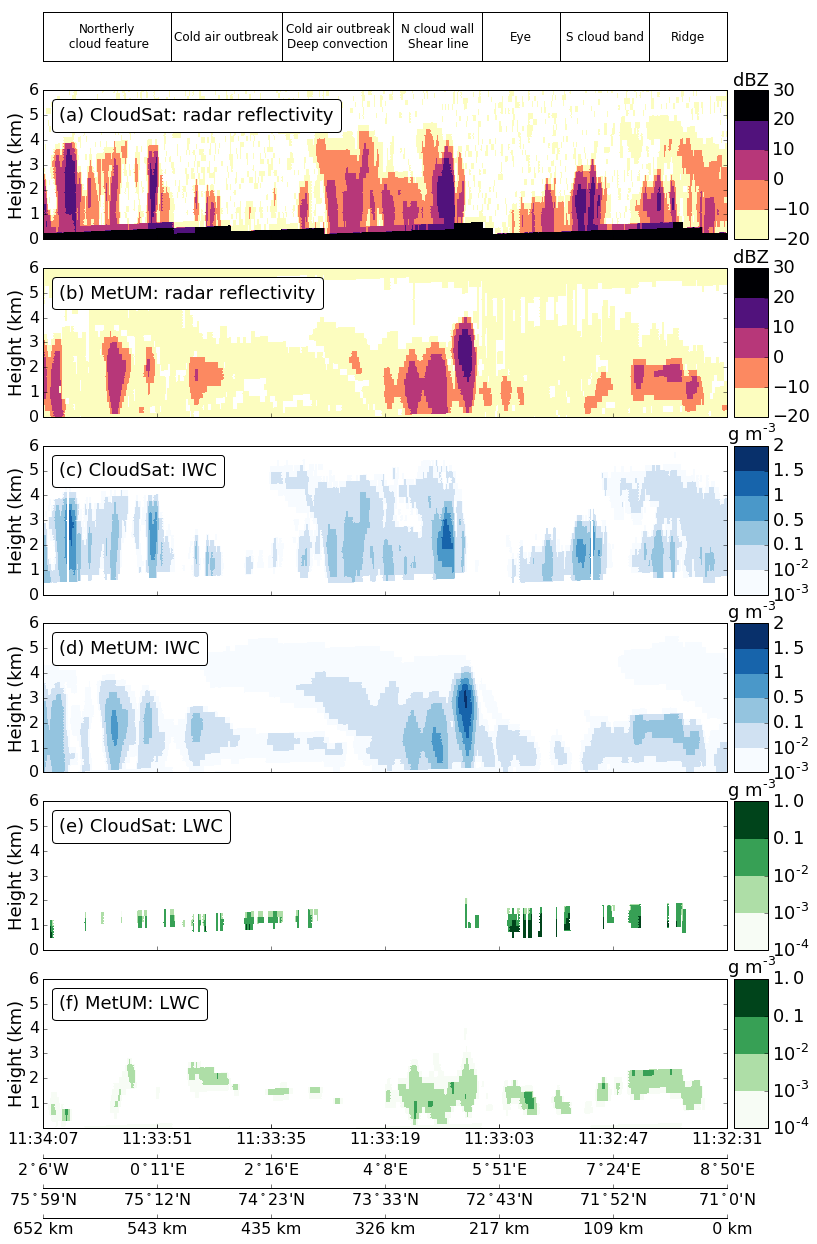

In [43]:
fig, axs, cbars = mympl.pcol_n_tseries_vs_hgt(varlist[:], time=cloudsat_time[i1:i2], lon=cloudsat_lons[i1:i2], lat=cloudsat_lats[i1:i2], 
                                       fs=(13, 20), add_dist=True, invert_xax=True, llstep=100, segments=segments_kw)
_ = axs[-1].set_yticks(range(1,7))
# c = axs[-1].contour(cloudsat_mdt, cloudsat_z, um_interp_airtemp, levels=np.arange(0,400,5), colors='r')
# clb = axs[-1].clabel(c, fmt='%3.0f', color='r')
fig.savefig(os.path.join('figures', 'um_km2p2_25T1200_cloudsat_vs_um_1130.{fmt}'.format(fmt=fmt)), **svfigkw)